In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sea
from scipy import stats
import matplotlib.pyplot as plt
from housing_elements import utils, los_altos_permits, san_francisco_permits, san_jose_permits

In [2]:
from importlib import reload
reload(los_altos_permits)
reload(san_francisco_permits)
reload(utils)

<module 'housing_elements.utils' from '/Users/Salim/Desktop/housing-elements/housing_elements/utils.py'>

In [3]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
# Silence an annoying warning that I get when running pd.read_excel
import warnings
warnings.filterwarnings("ignore", message="Data Validation extension is not supported and will be removed")

# Load sites and permits DataFrames for each city

In [5]:
# Load this once, to speed up load_site_inventory below
sites_df = utils.load_all_sites()

In [6]:
all_cities = sites_df.jurisdict.unique()

In [7]:
len(all_cities)

108

In [8]:
# Load this once, to speed up load_all_new_building_permits below
abag_permits_df = utils.load_abag_permits()

In [9]:
reload(utils)

<module 'housing_elements.utils' from '/Users/Salim/Desktop/housing-elements/housing_elements/utils.py'>

In [10]:
%%time
cities_with_sites = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_sites[city] = utils.load_site_inventory(city, sites_df=sites_df)
            cities_with_sites[city].relcapcty.sum()
        except Exception:
            pass

CPU times: user 8.36 s, sys: 175 ms, total: 8.54 s
Wall time: 8.71 s


In [11]:
len(cities_with_sites)

108

In [12]:
%%time
cities_with_permits = {}

for city in all_cities:
    with HiddenPrints():
        try:
            cities_with_permits[city] = utils.load_all_new_building_permits(city, abag_permits_df)
        except Exception:
            print(city, file=sys.stderr)

Contra Costa County
Alameda County
Corte Madera
Marin County
Saint Helena
Napa County
Hillsborough
San Mateo County
Sonoma County


CPU times: user 4min 55s, sys: 1.42 s, total: 4min 56s
Wall time: 4min 57s


Solano County


In [13]:
len(cities_with_permits)

98

In [14]:
reload(utils)

<module 'housing_elements.utils' from '/Users/Salim/Desktop/housing-elements/housing_elements/utils.py'>

## Data Cleaning Factoids

### Realistic Capacity

#### Pre-Existing Nulls

Two ways to calculate NA realistic capacities come to the same conclusion

In [15]:
rhna5 = sites_df[sites_df.rhnacyc == 'RHNA5']

In [16]:
rhna5.relcapcty[rhna5.relcapcty.isna()].shape

(2910,)

In [17]:
rhna5[(rhna5.relcapcty.str.contains("/^([^0-9]*)$/") != False)].shape

/Users/Salim/opt/miniconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(2910, 35)

In [18]:
rhna5.shape

(20849, 35)

In [19]:
2910 / rhna5.shape[0]

0.13957503957024317

### Proportion of nulls that are our fault versus theirs

In [20]:
for city, site in cities_with_sites.items():
    num_fail_parse_realcap = site.realcap_parse_fail.sum()
    num_fail_parse_allowden = site.allowden_parse_fail.sum()
    if num_fail_parse_realcap or num_fail_parse_allowden:
        print(city, end='\t')
    if num_fail_parse_realcap:
        print('Realcap', num_fail_parse_realcap)
    if num_fail_parse_allowden:
        print('Allowden', num_fail_parse_allowden)

San Ramon	Allowden 1
Newark	Allowden 1
Danville	Allowden 9
El Cerrito	Allowden 7
Walnut Creek	Allowden 90
Corte Madera	Allowden 1
Pittsburg	Allowden 1
Piedmont	Allowden 58
Sausalito	Allowden 87
Fairfax	Allowden 48
Novato	Allowden 5
Atherton	Allowden 2
Woodside	Allowden 266
San Mateo County	Allowden 136
Portola Valley	Allowden 8
Windsor	Allowden 1


In [21]:
sum([site.allowden_parse_fail.sum() for city, site in cities_with_sites.items()])

721

In [22]:
sum([site.realcap_parse_fail.sum() for city, site in cities_with_sites.items()])

0

In [23]:
sum([site.shape[0] for city, site in cities_with_permits.items()])

39851

In [24]:
721 / 39851

0.01809239416827683

In [25]:
sum([site.allowden_not_listed.sum() for city, site in cities_with_sites.items()])

5547

In [26]:
721 / (5547 + 721)

0.11502871729419273

11% of allowable density nulls are our fault. None of the realistic capacity nulls are our fault.

#### Degenerate Rows

In [27]:
no_realcap = pd.to_numeric(rhna5.relcapcty, errors='coerce') == 0
no_allowden = pd.to_numeric(rhna5.allowden, errors='coerce') == 0
no_locacreage = pd.to_numeric(rhna5.locacres, errors='coerce') == 0
no_gacreage = pd.to_numeric(rhna5.gacres, errors='coerce') == 0

In [28]:
rhna5[no_realcap & no_locacreage].shape

(14, 35)

In [29]:
rhna5[no_gacreage & no_locacreage].shape

(0, 35)

In [30]:
rhna5[no_gacreage].shape

(0, 35)

In [31]:
rhna5[no_realcap & no_allowden].shape

(901, 35)

In [32]:
rhna5[no_realcap & no_allowden & no_locacreage].shape

(0, 35)

I wouldn't say there are any degenerate rows. Even when locacreage is zero, we can rely on gacreage instead. 

There are, however, 901 sites with no realistic capacity and no allowable density. What kind of sites are these?

In [33]:
rhna5[no_realcap & no_allowden].jurisdict.value_counts()

San Francisco       884
Moraga               14
San Mateo County      2
Martinez              1
Name: jurisdict, dtype: int64

In [34]:
rhna5[no_realcap & no_allowden].sample(5, random_state =0)

,objectid,rhnacyc,rhnayrs,county,jurisdict,apn,locapn,genplan,zoning,gacres,...,infcapcty,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,Shape__Are,Shape__Len,geometry
28077,70211,RHNA5,2015-2023,6075,San Francisco,4227/031,4227/031,Central Waterfront,PDR-1-G,0.056,...,None,None,Underutilized,Y,None,Dwelling,None,2.312208e-08,0.000814,"POLYGON ((-122.39100 37.75430, -122.39132 37.7..."
30283,72417,RHNA5,2015-2023,6075,San Francisco,5434B/002,5434B/002,"BVHP Area A,B",PDR-2,0.697,...,None,None,Underutilized,Y,None,Industrial,None,2.884321e-07,0.002368,"POLYGON ((-122.39907 37.72771, -122.39941 37.7..."
33511,75645,RHNA5,2015-2023,6075,San Francisco,5333/029,5333/029,"BVHP Area A,B",PDR-2,0.057,...,None,None,Underutilized,Y,None,Industrial,None,2.374463e-08,0.000763,"POLYGON ((-122.40177 37.73906, -122.40197 37.7..."
32095,74229,RHNA5,2015-2023,6075,San Francisco,5230/021,5230/021,"BVHP Area A,B",PDR-2,1.122,...,None,None,Vacant,Y,None,Vacant,None,4.643043e-07,0.004282,"POLYGON ((-122.39653 37.74671, -122.39660 37.7..."
31946,74080,RHNA5,2015-2023,6075,San Francisco,4811/011,4811/011,"BVHP Area A,B",PDR-2,0.229,...,None,None,Underutilized,Y,None,Industrial,None,9.496034e-08,0.001248,"POLYGON ((-122.38719 37.72667, -122.38739 37.7..."


They're mostly in San Francisco and have a zoning type of PDR. According to SF's website, "In order to protect PDR, residential development would be prohibited, while office, retail, and institutional uses (schools, hospitals, etc.) would be limited. HOWEVER, residences, offices and retail which currently exist legally in these areas may stay indefinitely."

## Results

In [35]:
def get_results_for_city(city: str, match_by: str) -> pd.DataFrame:
    permits = cities_with_permits[city]
    sites = cities_with_sites[city]
    
    nonvacant_matches, nonvacant_sites, nonvacant_ratio = utils.calculate_pdev_for_nonvacant_sites(sites, permits, match_by)
    vacant_matches, vacant_sites, vacant_ratio = utils.calculate_pdev_for_vacant_sites(sites, permits, match_by)
    all_matches, all_sites, all_ratio = utils.calculate_pdev_for_inventory(sites, permits, match_by)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': nonvacant_ratio,
        'P(dev) for vacant sites': vacant_ratio,
        'P(dev) for inventory': all_ratio,
        '# nonvacant matches': f'{nonvacant_matches} / {nonvacant_sites}',
        '# vacant matches': f'{vacant_matches} / {vacant_sites}',
        '# matches': f'{all_matches} / {all_sites}',
    }

In [36]:
cities = [city for city in all_cities if city in cities_with_permits and city in cities_with_sites]

In [37]:
len(cities)

98

In [45]:
reload(utils)

<module 'housing_elements.utils' from '/Users/Salim/Desktop/housing-elements/housing_elements/utils.py'>

In [39]:
%%time
with HiddenPrints():
    results_df = pd.DataFrame([get_results_for_city(city, match_by='apn') for city in cities])

/Users/Salim/opt/miniconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1127: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/Users/Salim/opt/miniconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1127: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/Users/Salim/opt/miniconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1127: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/Users/Salim/opt/miniconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1127: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/Users/Salim/opt/miniconda3/envs/my_env/lib/python3.

CPU times: user 21 s, sys: 270 ms, total: 21.3 s
Wall time: 21.4 s


/Users/Salim/opt/miniconda3/envs/my_env/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1127: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [40]:
results_df[results_df['P(dev) for inventory'] == 0].City.values

array(['Albany', 'Alameda', 'Antioch', 'Union City', 'Walnut Creek',
       'Moraga', 'Hercules', 'Oakley', 'Tiburon', 'Sausalito', 'Ross',
       'Millbrae', 'Pacifica', 'Gilroy', 'East Palo Alto', 'Los Gatos',
       'Saratoga', 'Rohnert Park', 'Suisun City', 'Rio Vista',
       'Monte Sereno'], dtype=object)

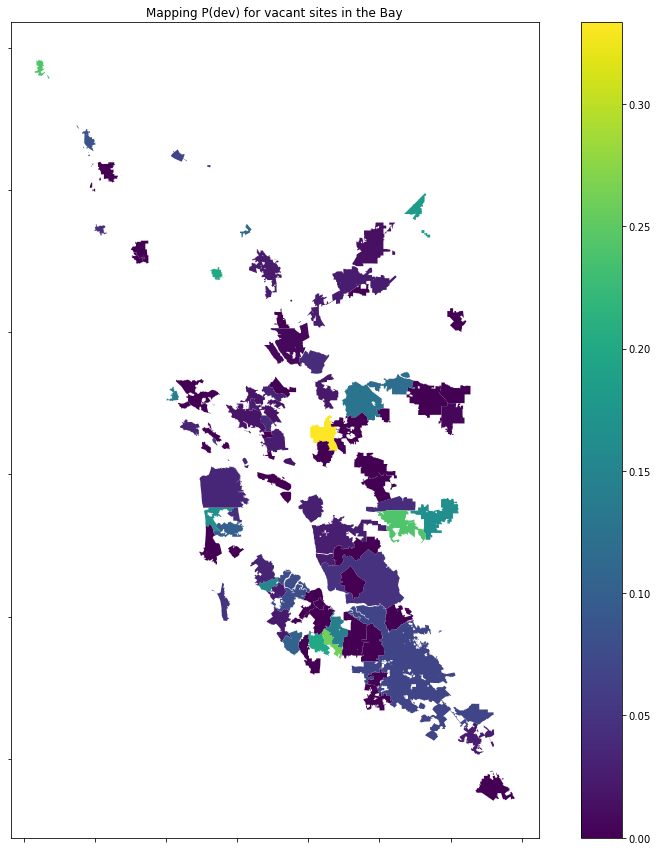

In [47]:
utils.map_qoi('P(dev) for vacant sites', results_df)

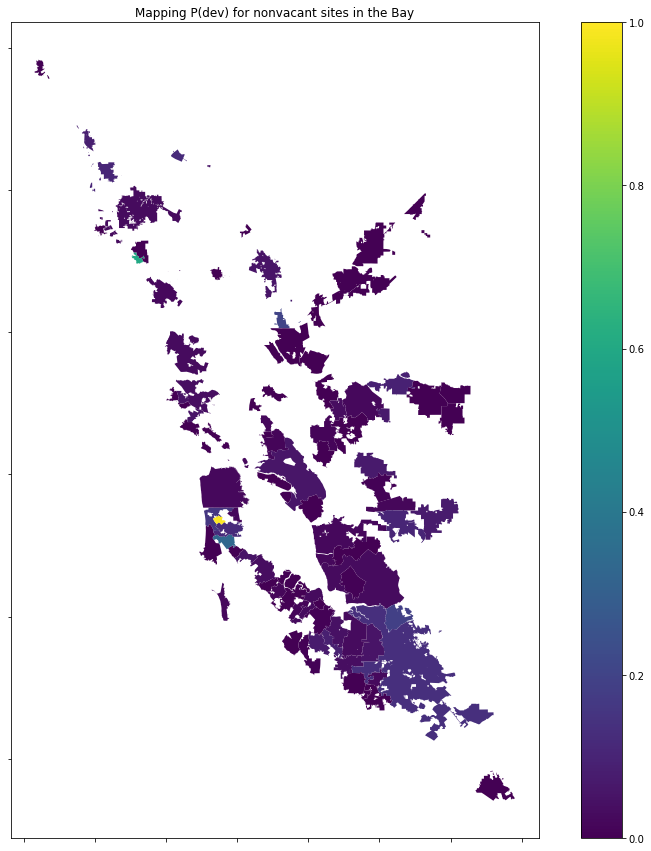

In [48]:
utils.map_qoi('P(dev) for nonvacant sites', results_df)

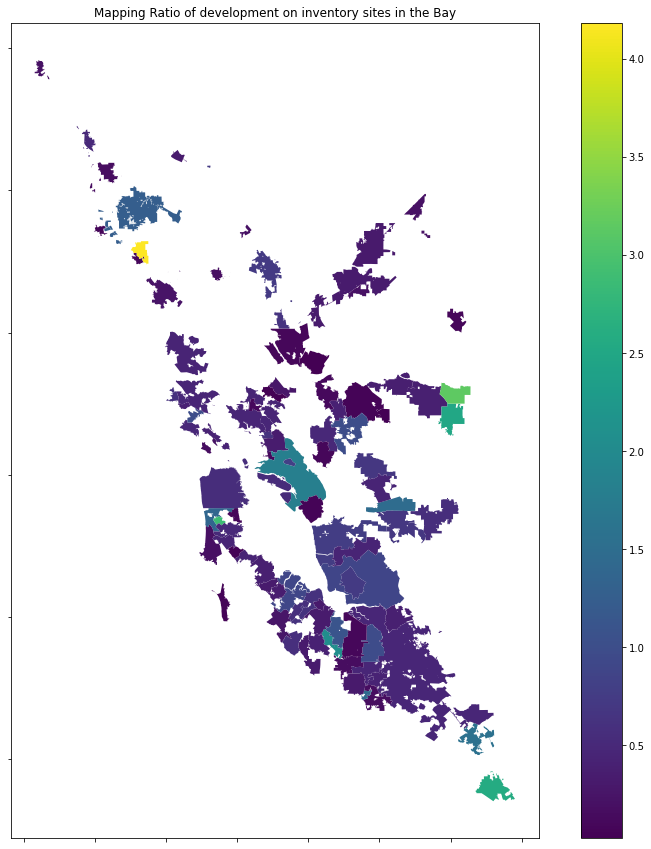

In [49]:
utils.map_qoi('Ratio of development on inventory sites', results_df)

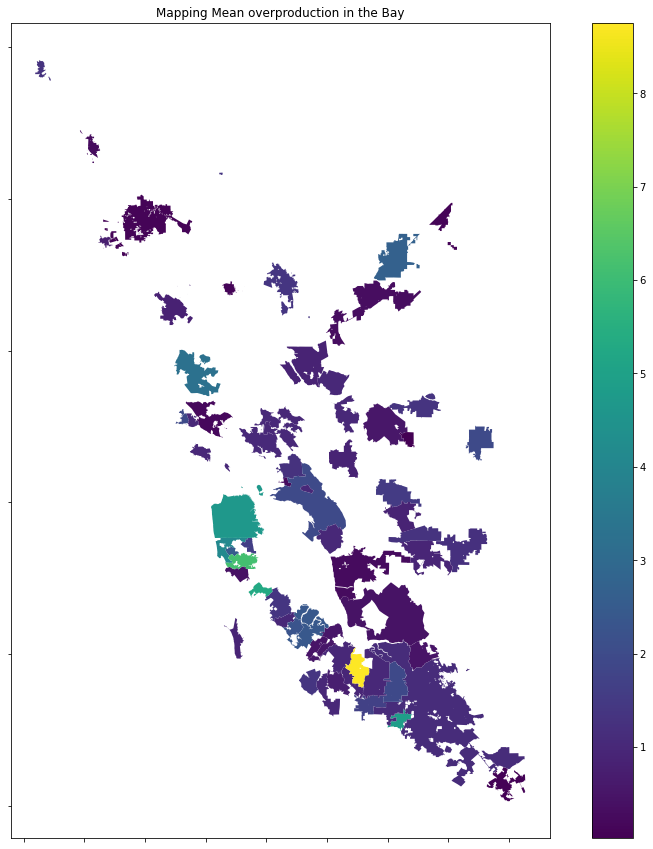

In [50]:
utils.map_qoi('Mean overproduction', results_df)

In [ ]:
utils.map_qoi('Ratio of development on inventory sites', results_df)

In [ ]:
results_df[results_df['P(dev) for inventory'].isna()]

In [ ]:
sites_df[sites_df.jurisdict == 'Orinda']

In [ ]:
reload(utils)
for city, permits in cities_with_permits.items():
    print(city, '\t', round(utils.fraction_apns_nan(permits), 2))

In [ ]:
cities_with_permits['Dublin'].apn.isna().mean()

In [ ]:
x = results_df["P(dev) for inventory"]
y = [utils.fraction_apns_nan(p) for c, p in cities_with_permits.items()]
plt.scatter(x, y, alpha=.2)
plt.xlabel("P(dev)")
plt.ylabel("% APNs NAN")
plt.title("Are missing APNs skewing our results?")

In [ ]:
%%time
with HiddenPrints():
    results_geo_df = pd.DataFrame([get_results_for_city(city, match_by='geo') for city in cities])

In [ ]:
results_geo_df.round(3)

In [ ]:
%%time
with HiddenPrints():
    results_both_df = pd.DataFrame([get_results_for_city(city, match_by='both') for city in cities])

In [ ]:
results_both_df.round(3)

### Histograms of QOIs

In [ ]:
sea_plot = sea.histplot(results_both_df['P(dev) for nonvacant sites']).set_title("Each city's P(dev) for nonvacant sites")
sea_plot.get_figure().savefig('./figures/Pdev_nonvacant.png')

In [ ]:
sea_plot = sea.histplot(results_both_df['P(dev) for vacant sites']).set_title("Each city's P(dev) for vacant sites")
sea_plot.get_figure().savefig('./figures/Pdev_vacant.png')

In [ ]:
sea_plot = sea.histplot(results_both_df['P(dev) for vacant sites']).set_title("Each city's P(dev)")
sea_plot.get_figure().savefig('./figures/Pdev.png')

In [ ]:
sea_plot = sea.histplot(results_both_df['Ratio of development on inventory sites']).set_title("Each city's 1 / P(inventory|dev)")
sea_plot.get_figure().savefig('./figures/ratio_of_dev.png')

In [ ]:
sea_plot = sea.histplot(results_both_df['Mean overproduction']).set_title("Each city's mean overproduction")
sea_plot.get_figure().savefig('./figures/mean_overproduction.png')

In [ ]:
sea_plot = sea.histplot(results_both_df['Inventory housing / all housing']).set_title("Each city's Inventory housing / all housing")
sea_plot.get_figure().savefig('./figures/inventory_housing_over_all_housing.png')


### Did RHNA success in last cycle actually have anything to do with how good the site inventory was?

In [ ]:
rhna_success = results_both_df['Ratio of development on inventory sites']
p_dev = results_both_df['P(dev) for inventory']

is_null = np.isnan(rhna_success) | np.isnan(p_dev)
stats.pearsonr(rhna_success[~is_null], p_dev[~is_null])

In [ ]:
sea_plot = sea.scatterplot(x=rhna_success[~is_null], y=p_dev[~is_null])
sea_plot.set_title("Does RHNA success have anything to do with the realistic capacity of the inventory sites?")
sea_plot.get_figure().savefig('./figures/did_realistic_capacity_calcs_matter.png')

### Table of top 10 cities by P(dev) & bottom 10

#### Worst

In [ ]:
results_both_df.sort_values(by='P(dev) for inventory').head(10)

#### Best

In [ ]:
results_both_df.sort_values(by='P(dev) for inventory', ascending=False).head(10)

In [ ]:
combined_df = results_df.merge(
    results_geo_df,
    on='City',
    suffixes=[' (by APN)', ' (by geomatching)']
)

In [ ]:
combined_df.round(3)

In [ ]:
results_df.to_csv('results/apn_matching_results.csv')
results_geo_df.to_csv('results/geo_matching_results.csv')
combined_df.to_csv('results/combined_df.csv')
results_both_df.to_csv('results/apn_or_geo_matching_results.csv')

Let's look into some cities where the APN results and Geo results are very out of line:

In [ ]:
combined_df[
    (combined_df['P(dev) for nonvacant sites (by APN)'] - combined_df['P(dev) for nonvacant sites (by geomatching)']).abs() > 0.3
]

In [ ]:
combined_df[
    combined_df['City'].isin(['Alameda', 'Antioch', 'Walnut Creek'])
]

In [ ]:
cities_with_sites['San Bruno']

In [ ]:
cities_with_sites['San Bruno'].plot()

In [ ]:
cities_with_permits['San Bruno'].plot()

In [ ]:
import contextily as cx

def plot_city(sites, permits):
    ax = sites.plot(color='blue', edgecolor='red', figsize=(15, 15))
    permits.plot(ax=ax, color='green', markersize=3)
    
#     cx.add_basemap(ax, zoom=18, crs='EPSG:4326')
#     cx.add_basemap(ax, zoom=16, crs='EPSG:4326')
#     cx.add_basemap(
#         ax,
#         source='https://tiles.stadiamaps.com/tiles/osm_bright/{z}/{x}/{y}{r}.png?api_key=c50d11b9-261a-4916-b968-fe8854621c78',
#         zoom=15,
#         crs='EPSG:4326'
#     )
    cx.add_basemap(
        ax,
        source=cx.providers.Stamen.TonerLite,
#         zoom=15,
        crs='EPSG:4326',
    )

In [ ]:
plot_city(cities_with_sites['San Bruno'], cities_with_permits['San Bruno'])

In [ ]:
sites = cities_with_sites['Windsor']
permits = cities_with_permits['Windsor']

In [ ]:
sites.columns

In [ ]:
sites[['apn', 'locapn', 'relcapcty', 'gacres', 'zoning', 'locacres', 'allowden']]

In [ ]:
permits[
    permits.apn.isin(
        sites.apn
    )
][['permyear', 'address', 'totalunit', 'apn']]

In [ ]:
permits[['permyear', 'address', 'totalunit']]

In [ ]:
sites.columns

In [ ]:
sites[
    sites['apn'] == 17080150.0
][['apn', 'locapn', 'relcapcty', 'gacres', 'locacres', 'localnote', 'index', 'existuse', 'sitetype', 'zoning']]

In [ ]:
plot_city(cities_with_sites['Windsor'], cities_with_permits['Windsor'])

In [ ]:
cities_with_permits['San Bruno'].columns

In [ ]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:k
    print(column, (combined_df[column + ' (by geomatching)'] >= combined_df[column + ' (by APN)']).mean())

In [ ]:
for column in ['P(dev) for nonvacant sites', 'P(dev) for vacant sites', 'P(dev) for inventory']:
    print(column, (combined_df[column + ' (by geomatching)'] == combined_df[column + ' (by APN)']).mean())

# "Ground truth" data

In [ ]:
def get_ground_truth_results_for_city(city: str) -> pd.DataFrame:
    if city == 'San Jose':
        permits = san_jose_permits.load_all_permits()
    elif city == 'San Francisco':
        permits = san_francisco_permits.load_all_permits()
    elif city == 'Los Altos':
        permits = los_altos_permits.load_all_permits()
    else:
        raise ValueError(f"Ground truth data not available for {city}")
        
    permits = utils.load_all_new_building_permits(city)
    sites = utils.load_site_inventory(city)
    
    return {
        'City': city,
        'Ratio of development on inventory sites': utils.calculate_total_units_permitted_over_he_capacity(sites, permits),
        'Mean overproduction': utils.calculate_underproduction_on_sites(sites, permits),
        'Inventory housing / all housing': utils.calculate_inventory_housing_over_all_housing(sites, permits),
        'P(dev) for nonvacant sites': utils.calculate_pdev_for_nonvacant_sites(sites, permits),
        'P(dev) for vacant sites': utils.calculate_pdev_for_vacant_sites(sites, permits),
        'P(dev) for inventory': utils.calculate_pdev_for_inventory(sites, permits),
    }

In [ ]:

permits = pd.read_csv("./data/raw_data/sf_permits.csv")
print(permits.columns)
date_cols = [c for c in permits.columns if 'Date' in c]
permits[date_cols] = permits[date_cols].apply(pd.to_datetime)

In [ ]:
print(permits.columns)

In [ ]:
%%time
ground_truth_cities = ['Los Altos', 'San Francisco']
ground_truth_results_df = pd.DataFrame([get_ground_truth_results_for_city(city) for city in ground_truth_cities])

In [ ]:
ground_truth_results_df